# Assignment 9: New Analysis

In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy.stats import poisson
from scipy.stats import lognorm
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import sklearn.mixture
import scipy.stats as ss
import seaborn as sns


## Part 1: Kelly Chang

### 0. Setup

In [2]:
np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

df.head()

,cx,cy,cz,unmasked,synapses,weighted
0,19,1369,55,5063,0,0.0
1,19,1369,166,3576,0,0.0
2,19,1369,277,4561,0,0.0
3,19,1369,388,1521,0,0.0
4,19,1369,499,1521,0,0.0


### 1. Visualize weighted data slices with edges removed

In [3]:
xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges, Z-layer by Z-layer.
left = 0;
right = len(xvals);
top = 0;
bottom = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = max(left, np.argmax(xhist>0.5))
    right = min(right, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = max(top, np.argmax(yhist>0.5))
    bottom = min(bottom, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[left]) | (df2['cx']>=xvals[right])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[top]) | (df2['cy']>=yvals[bottom])], inplace=True)
print "There are", len(df2), "bins after removing the edges."
df2.head()

There are 35112 bins after removing the edges.


,cx,cy,cz,unmasked,synapses,weighted
6292,448,1369,55,126357,153,238.063772
6293,448,1369,166,139932,207,290.840237
6294,448,1369,277,150269,194,253.824488
6295,448,1369,388,138071,159,226.410122
6296,448,1369,499,150842,258,336.278119


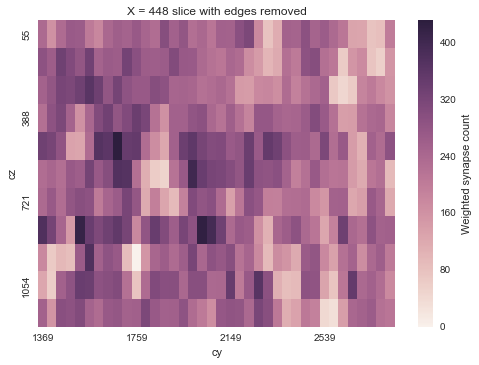

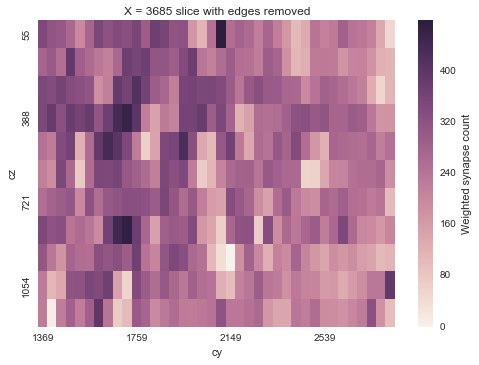

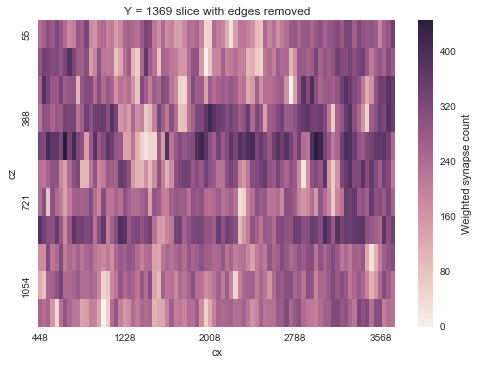

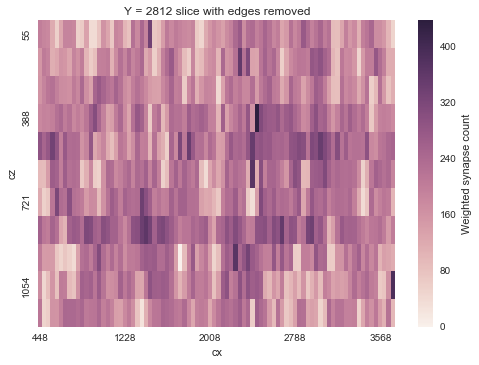

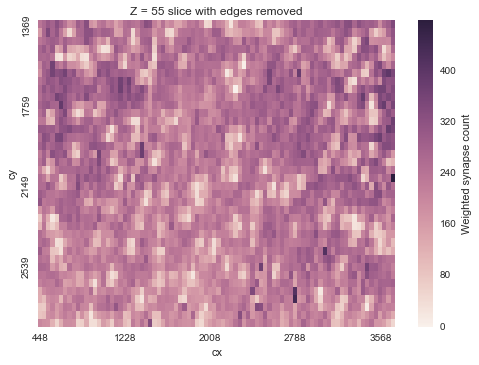

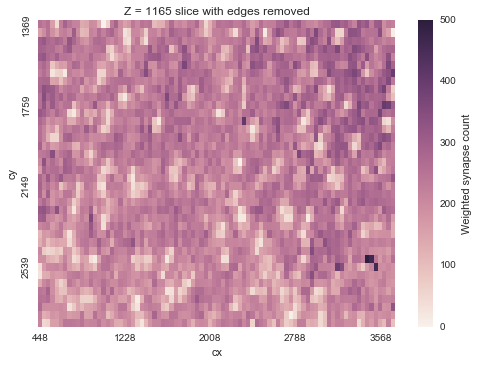

In [4]:
xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()

# Example X slices after removing edges
x = xvals[0]
Xslice = df2[df2['cx']==x].pivot_table(index='cz', columns='cy', values='weighted', aggfunc=np.sum)
plt.figure()
sns.heatmap(Xslice, xticklabels=10, yticklabels=3, 
            cbar_kws={'label': 'Weighted synapse count'});
plt.title('X = '+str(x)+' slice with edges removed');

x = xvals[-1]
Xslice = df2[df2['cx']==x].pivot_table(index='cz', columns='cy', values='weighted', aggfunc=np.sum)
plt.figure()
sns.heatmap(Xslice, xticklabels=10, yticklabels=3, 
            cbar_kws={'label': 'Weighted synapse count'});
plt.title('X = '+str(x)+' slice with edges removed');

# Example Y slices after removing edges
y = yvals[0]
Yslice = df2[df2['cy']==y].pivot_table(index='cz', columns='cx', values='weighted', aggfunc=np.sum)
plt.figure()
sns.heatmap(Yslice, xticklabels=20, yticklabels=3, 
            cbar_kws={'label': 'Weighted synapse count'});
plt.title('Y = '+str(y)+' slice with edges removed');

y = yvals[-1]
Yslice = df2[df2['cy']==y].pivot_table(index='cz', columns='cx', values='weighted', aggfunc=np.sum)
plt.figure()
sns.heatmap(Yslice, xticklabels=20, yticklabels=3, 
            cbar_kws={'label': 'Weighted synapse count'});
plt.title('Y = '+str(y)+' slice with edges removed');

# Example Z slices after removing edges
z = zvals[0]
Zslice = df2[df2['cz']==z].pivot_table(index='cy', columns='cx', values='weighted', aggfunc=np.sum)
plt.figure()
sns.heatmap(Zslice, xticklabels=20, yticklabels=10, 
            cbar_kws={'label': 'Weighted synapse count'});
plt.title('Z = '+str(z)+' slice with edges removed');

z = zvals[-1]
Zslice = df2[df2['cz']==z].pivot_table(index='cy', columns='cx', values='weighted', aggfunc=np.sum)
plt.figure()
sns.heatmap(Zslice, xticklabels=20, yticklabels=10, 
            cbar_kws={'label': 'Weighted synapse count'});
plt.title('Z = '+str(z)+' slice with edges removed');

### 2. Visualized weighted data 1D projections with edges removed

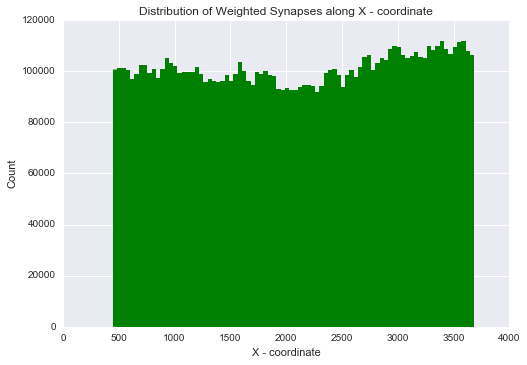

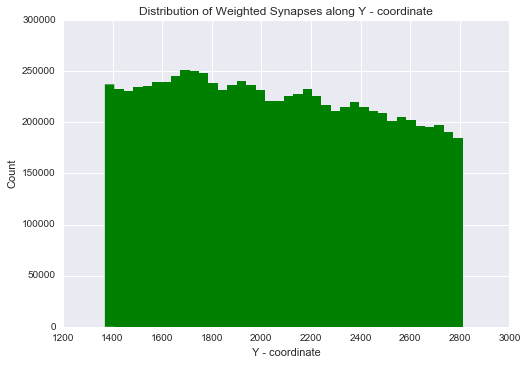

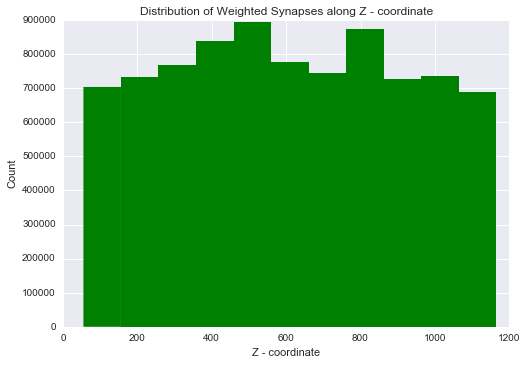

In [5]:
plt.figure()
plt.hist(df2['cx'], weights=df2['weighted'], bins=xvals.size, color='g', edgecolor='none')
plt.title('Distribution of Weighted Synapses along X - coordinate')
plt.xlabel('X - coordinate')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(df2['cy'], weights=df2['weighted'], bins=yvals.size, color='g', edgecolor='none')
plt.title('Distribution of Weighted Synapses along Y - coordinate')
plt.xlabel('Y - coordinate')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(df2['cz'], weights=df2['weighted'], bins=zvals.size, color='g', edgecolor='none')
plt.title('Distribution of Weighted Synapses along Z - coordinate')
plt.xlabel('Z - coordinate')
plt.ylabel('Count')
plt.show()


### 3. Visualize weighted data 2D projections with edges removed

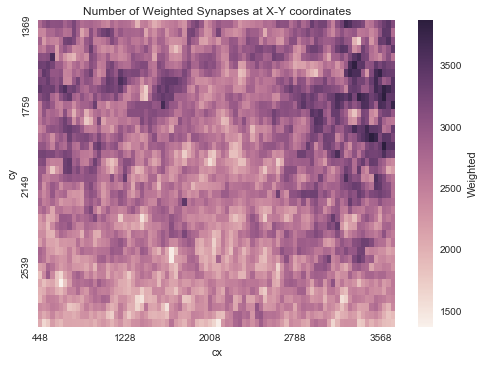

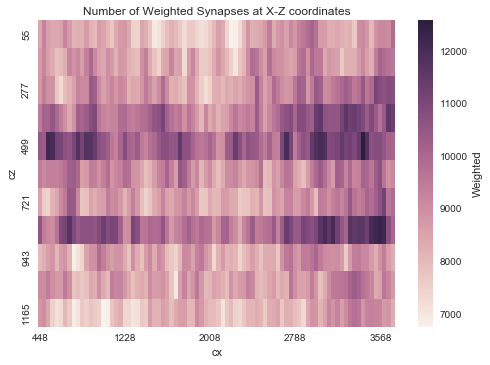

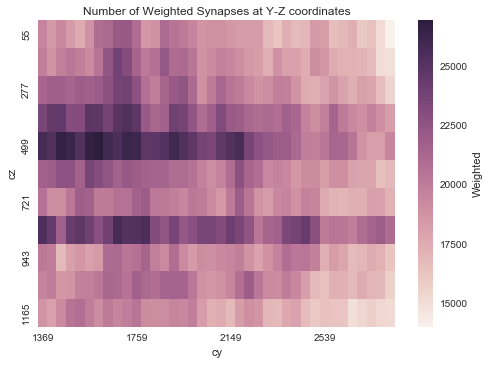

In [6]:
sumXY = pd.pivot_table(df2, index='cy', columns='cx', values='weighted', aggfunc=np.sum)
sumXZ = pd.pivot_table(df2, index='cz', columns='cx', values='weighted', aggfunc=np.sum)
sumYZ = pd.pivot_table(df2, index='cz', columns='cy', values='weighted', aggfunc=np.sum)

plt.figure()
sns.heatmap(sumXY, xticklabels=20, yticklabels=10, cbar_kws={'label': 'Weighted'});
plt.title('Number of Weighted Synapses at X-Y coordinates');

plt.figure()
sns.heatmap(sumXZ, xticklabels=20, yticklabels=2, cbar_kws={'label': 'Weighted'});
plt.title('Number of Weighted Synapses at X-Z coordinates');

plt.figure()
sns.heatmap(sumYZ, xticklabels=10, yticklabels=2, cbar_kws={'label': 'Weighted'});
plt.title('Number of Weighted Synapses at Y-Z coordinates');

### 4. 3D plot of weighted synapse data

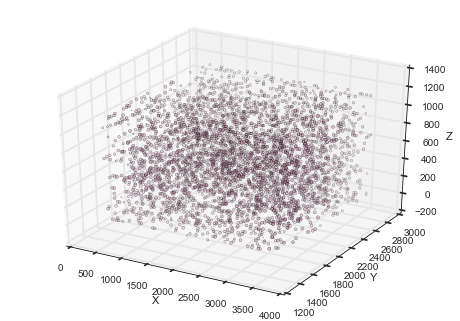

In [7]:
sns.set_style('white')

wt_max = df2['weighted'].max()
cmap = np.array(sns.cubehelix_palette(256))
cmap = np.hstack((cmap, np.linspace(0,1,256).reshape(-1,1)))
subsamp = np.random.choice(len(df2), size=len(df2)/9, replace=False) # reduce resolution
idx = df2.index[subsamp]
colors = [cmap[np.rint(255*(df2.ix[i]['weighted']/wt_max)).astype(int)] for i in idx]
ax = plt.figure().gca(projection='3d')
patches = ax.scatter(xs=df2.ix[idx]['cx'], ys=df2.ix[idx]['cy'], zs=df2.ix[idx]['cz'], 
                     s=20*(df2.ix[idx]['weighted']/wt_max), c=colors,
                     edgecolors=None)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_zlabel('Z')
plt.show()

### 5. 3D plot of high-density weighted synapse data

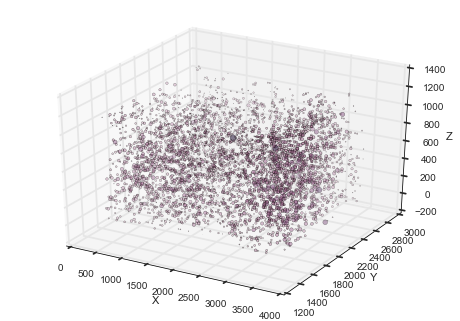

In [8]:
sns.set_style('white')

thresh = 250

wt_max = df2['weighted'].max()
cmap = np.array(sns.cubehelix_palette(256))
cmap = np.hstack((cmap, np.linspace(0,1,256).reshape(-1,1)))
df2thresh = df2[df2['weighted']>thresh] # high density data
subsamp = np.random.choice(len(df2thresh), size=len(df2thresh)/4, replace=False) # reduce resolution
idx = df2thresh.index[subsamp]
colors = [cmap[np.rint(255*(df2.ix[i]['weighted']/wt_max)).astype(int)] for i in idx]
ax = plt.figure().gca(projection='3d')
patches = ax.scatter(xs=df2.ix[idx]['cx'], ys=df2.ix[idx]['cy'], zs=df2.ix[idx]['cz'], 
                     s=40*((df2.ix[idx]['weighted']-thresh)/(wt_max-thresh)), c=colors,
                     edgecolors=None)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_zlabel('Z')
plt.show()

### 6. 3D plot of very high-density weighted synapse data

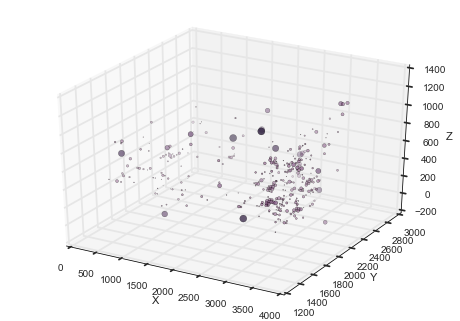

In [9]:
sns.set_style('white')

thresh = 400

wt_max = df2['weighted'].max()
cmap = np.array(sns.cubehelix_palette(256))
cmap = np.hstack((cmap, np.linspace(0,1,256).reshape(-1,1)))
df2thresh = df2[df2['weighted']>thresh] # high density data
idx = df2thresh.index
colors = [cmap[np.rint(255*(df2.ix[i]['weighted']/wt_max)).astype(int)] for i in idx]
ax = plt.figure().gca(projection='3d')
patches = ax.scatter(xs=df2.ix[idx]['cx'], ys=df2.ix[idx]['cy'], zs=df2.ix[idx]['cz'], 
                     s=50*((df2.ix[idx]['weighted']-thresh)/(wt_max-thresh)), c=colors,
                     edgecolors=None)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_zlabel('Z')
plt.show()

### 7. Histogram of weighted synapses with edges removed

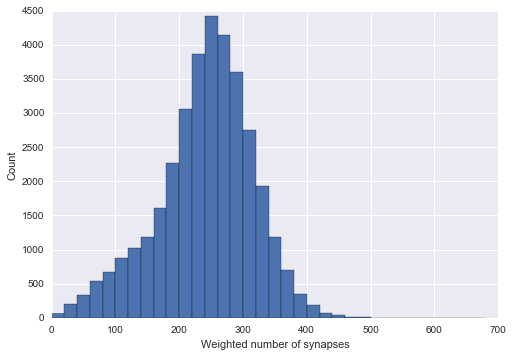

In [10]:
sns.set_style('darkgrid')

step = 20
bin_edges = np.arange(0,np.ceil(df2['weighted'].max()/step)*step+1,step)

plt.figure()
df2['weighted'].hist(bins=bin_edges)
plt.xlabel('Weighted number of synapses')
plt.ylabel('Count')
plt.show()

### 8. Chi-squared test for uniform distribution

In [11]:
mw = df2['weighted'].mean()
print "The mean weighted number of synapses is", mw
expected = [mw]*len(df2)
(chi2,p) = ss.chisquare(df2['weighted'], f_exp=expected, ddof=1)
print "chi-squared statistic: ", chi2
print "p-value: ", p

The mean weighted number of synapses is 241.521542264
chi-squared statistic:  812212.798375
p-value:  0.0


Since the p-value is very small, we reject the null hypothesis that synapses are uniformly distributed with 241.5 synapses per bin on average.

### 9. Boxplot of weighted synapses with edges removed

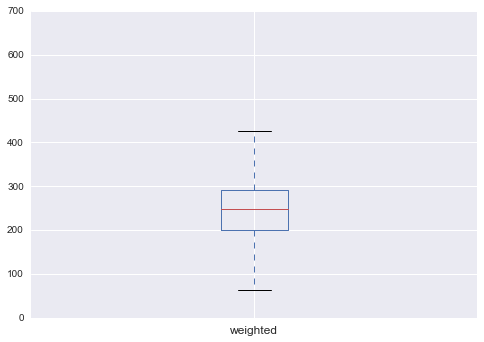

In [12]:
plt.figure()
df2.boxplot(column='weighted', return_type='dict')
plt.show()

### 10. FFT of weighted synapse data with edges removed

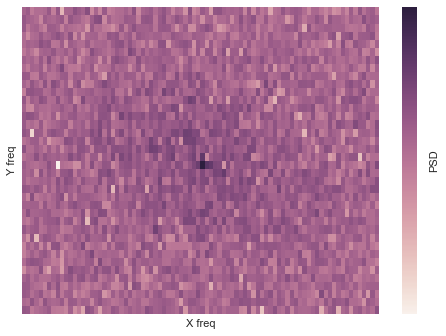

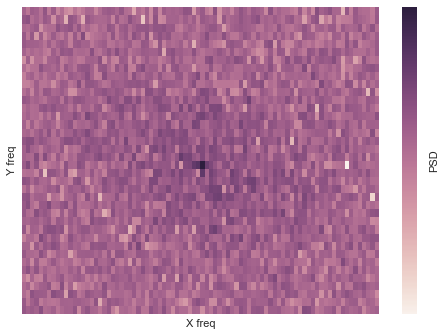

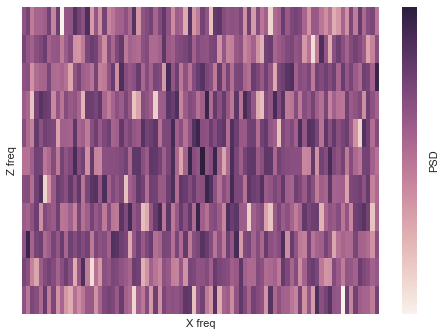

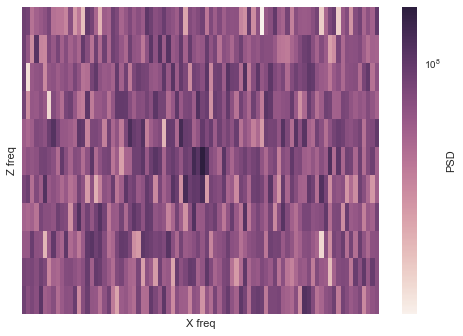

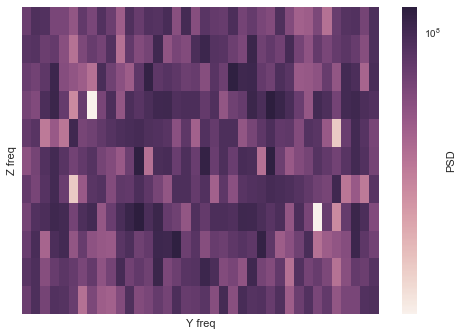

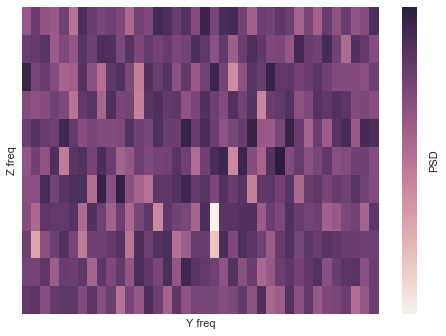

In [13]:
from matplotlib.colors import LogNorm

S = np.array([
        pd.pivot_table(df2[df2['cx']==x], index='cy', columns='cz', values='weighted', aggfunc=np.sum).values 
        for x in xvals
    ])

# print pd.pivot_table(df2[df2['cx']==x], index='cy', columns='cz', values='weighted', aggfunc=np.sum).head()

FS = np.fft.fftn(S)
PSD = np.abs(np.fft.fftshift(FS))**2

# Example XY slices
plt.figure()
data = PSD[:,:,0].T
sns.heatmap(data, xticklabels=False, yticklabels=False, 
            norm=LogNorm(vmin=data.min(), vmax=data.max()),
           cbar_kws={'label': 'PSD'})
plt.xlabel('X freq')
plt.ylabel('Y freq')
plt.show()

plt.figure()
data = PSD[:,:,-1].T
sns.heatmap(data, xticklabels=False, yticklabels=False, 
            norm=LogNorm(vmin=data.min(), vmax=data.max()),
           cbar_kws={'label': 'PSD'})
plt.xlabel('X freq')
plt.ylabel('Y freq')
plt.show()


# Example XZ slices
plt.figure()
data = PSD[:,0,:].T
sns.heatmap(data, xticklabels=False, yticklabels=False, 
            norm=LogNorm(vmin=data.min(), vmax=data.max()),
           cbar_kws={'label': 'PSD'})
plt.xlabel('X freq')
plt.ylabel('Z freq')
plt.show()

plt.figure()
data = PSD[:,-1,:].T
sns.heatmap(data, xticklabels=False, yticklabels=False, 
            norm=LogNorm(vmin=data.min(), vmax=data.max()),
           cbar_kws={'label': 'PSD'})
plt.xlabel('X freq')
plt.ylabel('Z freq')
plt.show()

# Example YZ slices
plt.figure()
data = PSD[0,:,:].T
sns.heatmap(data, xticklabels=False, yticklabels=False, 
            norm=LogNorm(vmin=data.min(), vmax=data.max()),
           cbar_kws={'label': 'PSD'})
plt.xlabel('Y freq')
plt.ylabel('Z freq')
plt.show()

plt.figure()
data = PSD[-1,:,:].T
sns.heatmap(data, xticklabels=False, yticklabels=False, 
            norm=LogNorm(vmin=data.min(), vmax=data.max()),
           cbar_kws={'label': 'PSD'})
plt.xlabel('Y freq')
plt.ylabel('Z freq')
plt.show()

## Part 2: San-He Wu

### (1) Setup

In [68]:
# Read in data
df = pd.read_csv('../output.csv')

### (1) Cut out the edges and plot the 2-D synapses density

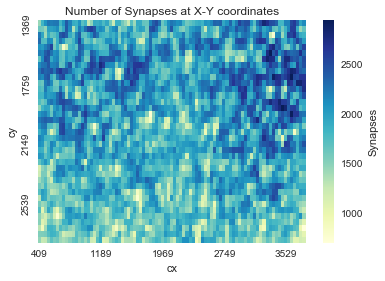

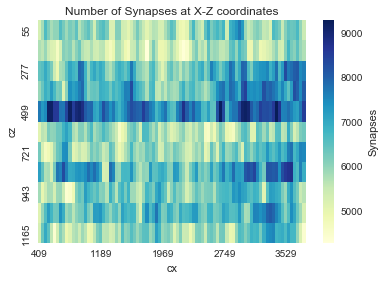

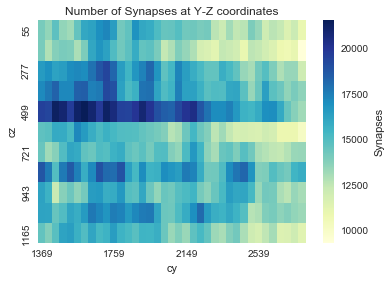

In [69]:
nvox = 64*64*48
dfcut = df[(df['cx'] > 400) & (df['cx'] < 3800) & (df['cy'] < 2800)]
dfftr = dfcut[dfcut['unmasked'] > nvox * 0.5]

sumXY = pd.pivot_table(dfftr, index='cy', columns='cx', values='synapses', aggfunc=np.sum)
sumXZ = pd.pivot_table(dfftr, index='cz', columns='cx', values='synapses', aggfunc=np.sum)
sumYZ = pd.pivot_table(dfftr, index='cz', columns='cy', values='synapses', aggfunc=np.sum)

import seaborn as sns

plt.figure()
sns.heatmap(sumXY, xticklabels=20, yticklabels=10, cbar_kws={'label': 'Synapses'}, cmap="YlGnBu");
plt.title('Number of Synapses at X-Y coordinates');

plt.figure()
sns.heatmap(sumXZ, xticklabels=20, yticklabels=2, cbar_kws={'label': 'Synapses'}, cmap="YlGnBu");
plt.title('Number of Synapses at X-Z coordinates');

plt.figure()
sns.heatmap(sumYZ, xticklabels=10, yticklabels=2, cbar_kws={'label': 'Synapses'}, cmap="YlGnBu");
plt.title('Number of Synapses at Y-Z coordinates');

## (2) 3D plot of new data set

C:\Users\Tri\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


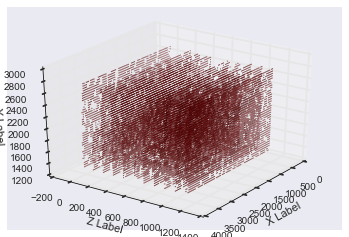

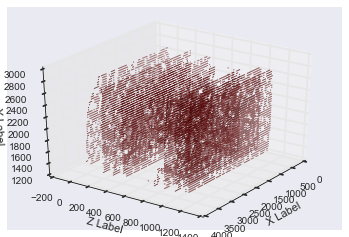

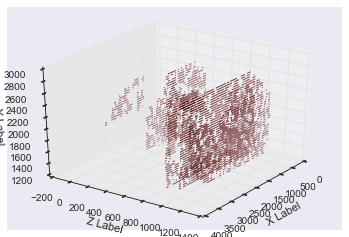

In [105]:
nvox = 64 * 64 * 48
dfcut['weighted'] = dfcut['synapses'] / dfcut['unmasked'] * nvox
dfthr = dfcut[dfcut['unmasked'] > nvox * 0.5]

k = [0.7, 0.75, 0.8]
for j in k:
    dfweg = dfcut[dfcut['unmasked'] > nvox * j] # Thresholded data frame
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    c = 'r'
    m = '8'
    xs = dfweg['cx']
    ys = dfweg['cy']
    zs = dfweg['cz'] 
    ax.scatter(xs, zs, ys, c=c, marker = m, s = 0.65)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    ax.view_init(azim = 35)
    fig.show()

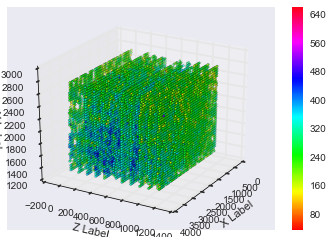

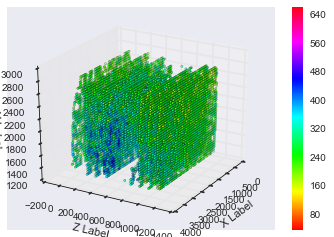

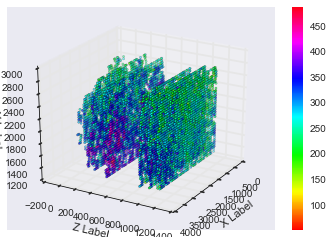

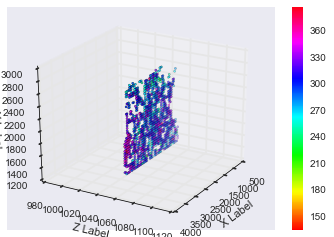

In [106]:
for i in ([0.7, 0.75, 0.78, 0.82]):
    dfweg = dfcut[dfcut['unmasked'] > nvox * i] # Thresholded data frame
    fig = plt.figure(figsize=(6, 4))

    ax = fig.add_subplot(111, projection='3d')
    xs = dfweg['cx']
    ys = dfweg['cy']
    zs = dfweg['cz'] 
    the_fourth_dimension = dfweg['weighted']

    colors = cm.hsv(the_fourth_dimension/max(the_fourth_dimension))

    colmap = cm.ScalarMappable(cmap=cm.hsv)
    colmap.set_array(the_fourth_dimension)
    m = '8'
    yg = ax.scatter(xs, zs, ys, c = colors, marker = m, s  = 5)
    cb = fig.colorbar(colmap)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    ax.view_init(elev = 25, azim = 30)

    plt.show()

It basically tell us that the higher synapses accumulated in such Z-layer, not randomly distributed.

## (3)Uniform distribution in the whole data set

In [19]:
sample = dfthr['weighted']

m = 8 # bin number
boundary = np.linspace(100, 500, m + 1)

exp_freq = len(sample) / 10

bin_content = []
for i in boundary:
    bin_content = np.append(bin_content, sum(sample <= i))
                          
obe_freq = []
for i in range(0, m + 1):
    if i == 0:
        obe_freq = np.append(obe_freq, bin_content[i])
    if i > 0:
        obe_freq = np.append(obe_freq, bin_content[i] - bin_content[i - 1])
         
observed_values = obe_freq

test_value = stats.chisquare(observed_values, f_exp = exp_freq)[1]

print test_value

0.0


Since p-value is nearly 0.0, it strongly rejects the null hypothesis that the new data set follows uniform distribution.

## (4) one-way ANOVA by Z-layer

In [32]:
arr_z = []

for i in range(0, 6):
    arr_z.append(dfthr[dfthr['cz'] == dfthr['cz'].unique()[i]]['weighted'])

stats.f_oneway(arr_z[0],arr_z[1],arr_z[2],arr_z[3],arr_z[4],arr_z[5])

F_onewayResult(statistic=368.24957207690682, pvalue=0.0)

Since p-value is nearly 0, it suggests that the mean of synapses are not equal in each Z-layer.

## (5) Normal distribution assumption in Z-layer

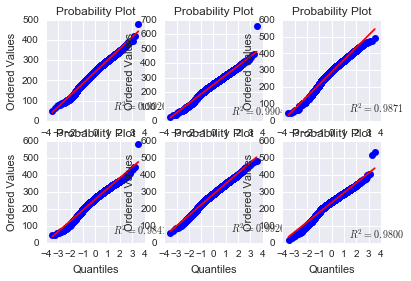

In [33]:
for i, j in zip(range(0, 6), [231, 232, 233, 234, 235, 236]):
    ax = plt.subplot(j)
    x = arr_z[i]
    res = stats.probplot(x, plot = plt)

Check the assumption of ANOVA, it suggests that the synapses in each Z-layer are normally distributed.

## (6) Aggregated Y into 4 layers and do one-way ANOVA

In [126]:
scy = sorted(dfthr['cy'].unique())

sy1 = dfthr[(dfthr['cy'] >= scy[0]) & (dfthr['cy'] <= scy[9])]
sy2 = dfthr[(dfthr['cy'] >= scy[9]) & (dfthr['cy'] <= scy[19])]
sy3 = dfthr[(dfthr['cy'] >= scy[19]) & (dfthr['cy'] <= scy[29])]
sy4 = dfthr[(dfthr['cy'] >= scy[29]) & (dfthr['cy'] <= scy[36])]
    
print(stats.f_oneway(sy1['weighted'], sy2['weighted'], sy3['weighted'], sy4['weighted']))
print 
yset = [sy1, sy2, sy3, sy4]

for i in range(0, 4):
    print "Variance of layer %d is: %d" % (i+1, np.var(yset[i]['weighted']))
    print "Mean of layer %d is: %7d" % (i+1, np.average(yset[i]['weighted']))


F_onewayResult(statistic=886.47925998354947, pvalue=0.0)

Variance of layer 1 is: 4481
Mean of layer 1 is:     271
Variance of layer 2 is: 4340
Mean of layer 2 is:     263
Variance of layer 3 is: 3804
Mean of layer 3 is:     245
Variance of layer 4 is: 3455
Mean of layer 4 is:     224


Since the p-value are nearly 0, it suggests that the mean synapses are not the same in each Y-layer.

## (7) Pairwised t-test in 4 Y-layers

In [46]:
print stats.ttest_ind(sy1['weighted'], sy2['weighted'], equal_var = True)
print stats.ttest_ind(sy1['weighted'], sy3['weighted'], equal_var = True)
print stats.ttest_ind(sy1['weighted'], sy4['weighted'], equal_var = True)
print stats.ttest_ind(sy2['weighted'], sy3['weighted'], equal_var = True)
print stats.ttest_ind(sy2['weighted'], sy4['weighted'], equal_var = True)
print stats.ttest_ind(sy3['weighted'], sy4['weighted'], equal_var = True)


Ttest_indResult(statistic=8.423479619012161, pvalue=3.9160570086398962e-17)
Ttest_indResult(statistic=28.044919429640036, pvalue=1.465147815226817e-169)
Ttest_indResult(statistic=47.304576326210821, pvalue=0.0)
Ttest_indResult(statistic=19.990375403151237, pvalue=4.9913253116494681e-88)
Ttest_indResult(statistic=40.378974708042719, pvalue=0.0)
Ttest_indResult(statistic=22.771007291529369, pvalue=4.402447471075322e-113)


According to the results, it turns out that each Y-layer are significantly different from each other.

## (8) Clustering in Y-layer

[[ 341.59445057  332.78173654  244.5122314  ...,  153.03616824
   248.18366864  194.12977371]
 [ 247.64326477  134.28968621  279.13290032 ...,  197.65381385
   159.70372074  130.0616659 ]
 [ 313.52990054  271.19743203  274.18959414 ...,  243.70923444
   346.13847387  298.50269424]
 ..., 
 [ 277.73620818  352.84854107  226.92863768 ...,  354.54404198
   189.22810395  271.72789036]
 [ 180.49451895  354.47194941  177.39109678 ...,  123.63364339
   259.52088567  236.0240096 ]
 [ 170.99490893  332.00008305  260.90186117 ...,  237.89620866
   268.56444725  311.38336411]]
Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.


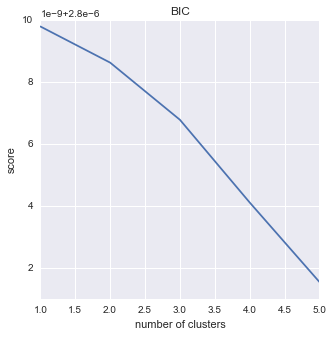

[ 355899.29845653  356047.03681729  356280.92389256  356619.84825926
  356946.24973577]


In [112]:
out = []
Yvalue = np.unique(dfthr['cy'])
minlen = 10000000

for i in Yvalue:
    temp = len(dfthr[dfthr['cy'] == i])
    if temp < minlen:
        minlen = temp
        
for i in Yvalue:
    if i == 1369:
        temp = dfthr[dfthr['cy'] == i]['weighted']
        out = np.random.choice(temp, minlen)
    else :
        temp = dfthr[dfthr['cy'] == i]['weighted']
        sample = np.random.choice(temp, minlen)
        out = np.column_stack((out, sample))

nclusters = range(1, 6)

bic = np.array(())
for idx in nclusters:
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = sklearn.mixture.GMM(n_components=idx, n_iter=1000, covariance_type = 'diag')
    gmm.fit(out)
    bic = np.append(bic, gmm.bic(out))
plt.figure(figsize=(5, 5))
plt.plot(nclusters, 1.0/bic)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()
print bic

However, based on the result of clustering, it turns out that Y-layers are identical.

## (9) Use the whole dataset to do clustering

C:\Users\Tri\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


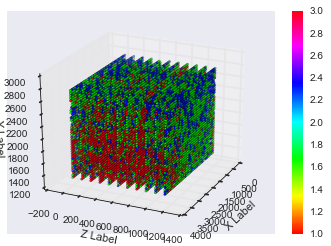

In [107]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

data = dfthr['weighted']

est = KMeans(n_clusters = 3)
est.fit(data.reshape(len(data),1))
labels = est.labels_
dfthr['pred'] = labels + 1

fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(111, projection='3d')
xs = dfthr['cx']
ys = dfthr['cy']
zs = dfthr['cz'] 
the_fourth_dimension = dfthr['pred']

colors = cm.hsv(the_fourth_dimension/max(the_fourth_dimension))

colmap = cm.ScalarMappable(cmap=cm.hsv)
colmap.set_array(the_fourth_dimension)
m = '8'
yg = ax.scatter(xs, zs, ys, c = colors, marker = m, s  = 5)
cb = fig.colorbar(colmap)

ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')
ax.view_init(elev = 25, azim = 25)

plt.show()

## (10) Try using Ordinary Least Square to fit linear model

In [100]:
import statsmodels.api as sm
X = dfthr[['cz','cx','cy']]
y = dfthr['weighted']

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               weighted   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     1012.
Date:                Wed, 30 Mar 2016   Prob (F-statistic):               0.00
Time:                        22:49:58   Log-Likelihood:            -1.8322e+05
No. Observations:               32943   AIC:                         3.665e+05
Df Residuals:                   32939   BIC:                         3.665e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        329.8401      2.008    164.266      0.0

In [101]:
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:,i] = X[name]/np.linalg.norm(X[name])
norm_xtx = np.dot(norm_x.T, norm_x)

eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number)

inf


Obviously, the result is very awful. Synapses density cannot be fitted with regression, at least simple linear regression is not applicable.

## Part 3: Andrew Cheng

### 0) Setup

In [34]:
np.random.seed(12345678)

df = pd.read_csv('../output.csv')


create weighted. Throw out bins with unmasked<=.5*nvox

In [11]:
nvox = 64*64*48
df['weighted'] = df['synapses']/df['unmasked']*nvox

dfthr = df[df['unmasked']>nvox*0.5] # Thresholded data frame

### 1) 2D exploratory graphs with weighted data

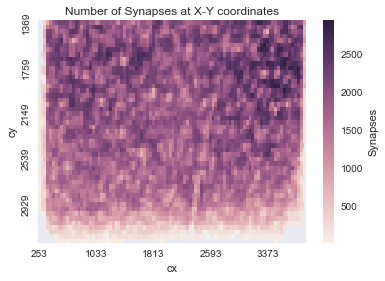

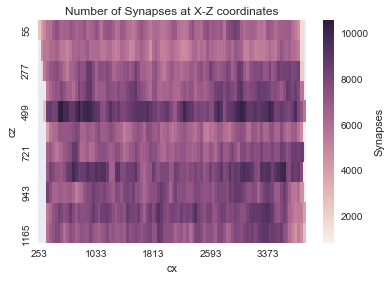

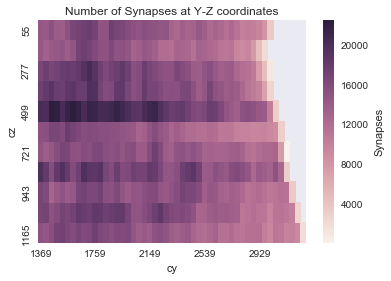

In [12]:
sumXY = pd.pivot_table(dfthr, index='cy', columns='cx', values='synapses', aggfunc=np.sum)
sumXZ = pd.pivot_table(dfthr, index='cz', columns='cx', values='synapses', aggfunc=np.sum)
sumYZ = pd.pivot_table(dfthr, index='cz', columns='cy', values='synapses', aggfunc=np.sum)

plt.figure()
sns.heatmap(sumXY, xticklabels=20, yticklabels=10, cbar_kws={'label': 'Synapses'});
plt.title('Weighted Number of Synapses at X-Y coordinates');

plt.figure()
sns.heatmap(sumXZ, xticklabels=20, yticklabels=2, cbar_kws={'label': 'Synapses'});
plt.title('Weighted Number of Synapses at X-Z coordinates');

plt.figure()
sns.heatmap(sumYZ, xticklabels=10, yticklabels=2, cbar_kws={'label': 'Synapses'});
plt.title('Weighted Number of Synapses at Y-Z coordinates');

### 1a) comparison with non-weighted plots

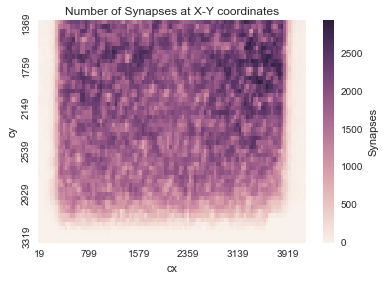

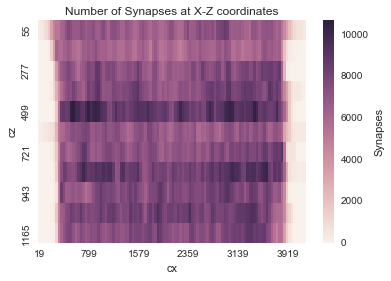

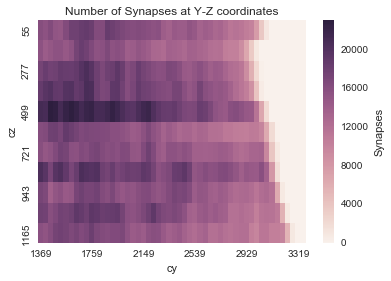

In [13]:
sumXY = pd.pivot_table(df, index='cy', columns='cx', values='synapses', aggfunc=np.sum)
sumXZ = pd.pivot_table(df, index='cz', columns='cx', values='synapses', aggfunc=np.sum)
sumYZ = pd.pivot_table(df, index='cz', columns='cy', values='synapses', aggfunc=np.sum)

plt.figure()
sns.heatmap(sumXY, xticklabels=20, yticklabels=10, cbar_kws={'label': 'Synapses'});
plt.title('Number of Synapses at X-Y coordinates');

plt.figure()
sns.heatmap(sumXZ, xticklabels=20, yticklabels=2, cbar_kws={'label': 'Synapses'});
plt.title('Number of Synapses at X-Z coordinates');

plt.figure()
sns.heatmap(sumYZ, xticklabels=10, yticklabels=2, cbar_kws={'label': 'Synapses'});
plt.title('Number of Synapses at Y-Z coordinates');

### 2) cut off edges

[ 253  292  331  370  409  448  487  526  565  604  643  682  721  760  799
  838  877  916  955  994 1033 1072 1111 1150 1189 1228 1267 1306 1345 1384
 1423 1462 1501 1540 1579 1618 1657 1696 1735 1774 1813 1852 1891 1930 1969
 2008 2047 2086 2125 2164 2203 2242 2281 2320 2359 2398 2437 2476 2515 2554
 2593 2632 2671 2710 2749 2788 2827 2866 2905 2944 2983 3022 3061 3100 3139
 3178 3217 3256 3295 3334 3373 3412 3451 3490 3529 3568 3607 3646 3685 3724
 3763 3802 3841 3880]


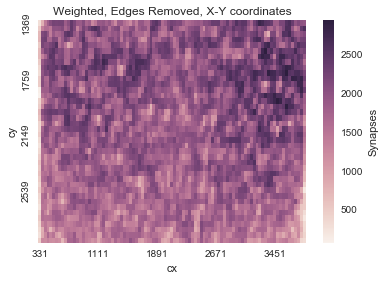

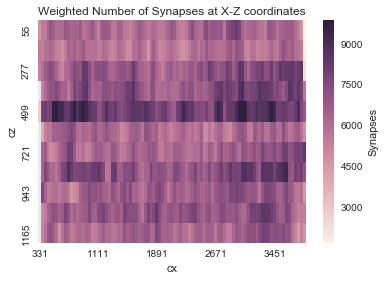

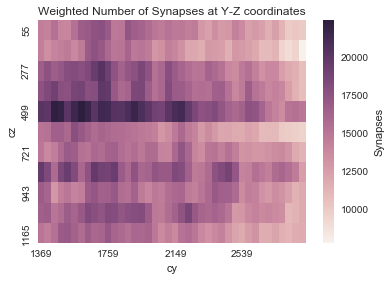

In [20]:
cxu = dfthr['cx'].unique()
print cxu

dfcut = dfthr[(dfthr['cx']>=331) & (dfthr['cx']<=3841) & (dfthr['cy']<=2905)] 
sumXY = pd.pivot_table(dfcut, index='cy', columns='cx', values='synapses', aggfunc=np.sum)
sumXZ = pd.pivot_table(dfcut, index='cz', columns='cx', values='synapses', aggfunc=np.sum)
sumYZ = pd.pivot_table(dfcut, index='cz', columns='cy', values='synapses', aggfunc=np.sum)

plt.figure()
sns.heatmap(sumXY, xticklabels=20, yticklabels=10, cbar_kws={'label': 'Synapses'});
plt.title('Weighted, Edges Removed, X-Y coordinates');

plt.figure()
sns.heatmap(sumXZ, xticklabels=20, yticklabels=2, cbar_kws={'label': 'Synapses'});
plt.title('Weighted Number of Synapses at X-Z coordinates');

plt.figure()
sns.heatmap(sumYZ, xticklabels=10, yticklabels=2, cbar_kws={'label': 'Synapses'});
plt.title('Weighted Number of Synapses at Y-Z coordinates');


### 3) 3D plot: Scatterplots of weighted/edges-removed data

664.574914495 16.4993426267


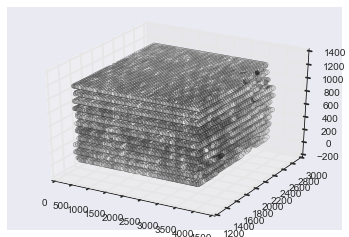

In [75]:
print dfcut['weighted'].max(), dfcut['weighted'].min()

colorBinned = np.round(20*(dfcut['weighted'] - dfcut['weighted'].min())/(dfcut['weighted'].max() - dfcut['weighted'].min()))
# print np.unique(colorBinned)
# print np.arange(20)
colors = cm.gray(np.linspace(0, 1, len(colorBinned)))
# print colors[np.arange(21)]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(np.arange(21),np.arange(21),zs = np.arange(21),c = colors[np.arange(21)])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfcut['cx'],dfcut['cy'],zs=dfcut['cz'],c=colorBinned)

### 3a) 3D plot at various thresholds

[ 0.]
[ 1.  2.  3.  4.  5.]
[  6.   7.   8.   9.  10.]
[ 11.  12.  13.  14.  15.]
[ 16.  17.  18.  19.  20.]


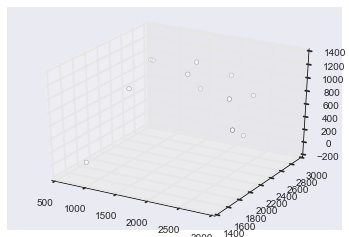

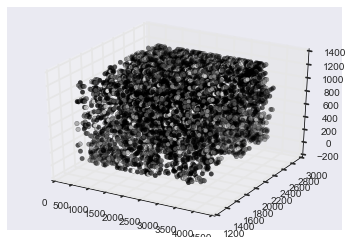

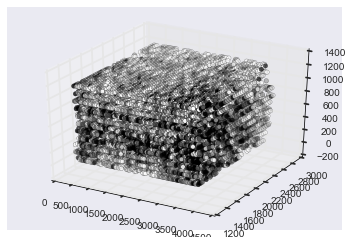

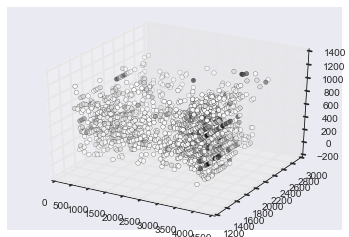

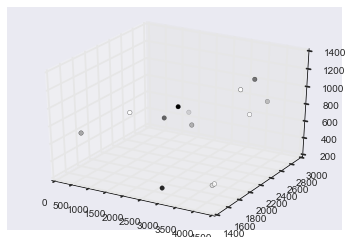

In [83]:
colorBinned = np.round(20*(dfcut['weighted'] - dfcut['weighted'].min())/(dfcut['weighted'].max() - dfcut['weighted'].min()))
# print np.unique(colorBinned)
# unqColor = np.unique(colorBinned)
for cc in [0,5,10,15,20]:
    curDf = dfcut[(colorBinned<=cc) & (colorBinned>cc-5)]
    curColor = colorBinned[(colorBinned<=cc) & (colorBinned>cc-5)]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(curDf['cx'],curDf['cy'],zs=curDf['cz'],c=curColor)
    print np.unique(curColor)

### 4) uniform distribution testing

In [88]:
print 'mean weighted: ', dfcut['weighted'].mean()

(chi2,p) = ss.chisquare(dfcut['weighted'],f_exp=dfcut['weighted'].mean(),ddof=1)
print "chi-squared statistic: ",chi2
print "p-value: ", p

mean weighted:  250.359322754
chi-squared statistic:  661299.233928
p-value:  0.0


### 5) Hypothesis test: 

In [112]:
miny = dfcut['cy'].min()
maxy = dfcut['cy'].max()
th0 = miny
th1 = (maxy - miny)/4 + miny
th2 = (maxy - miny)/2 + miny
th3 = (maxy - miny)*3/4 + miny
th4 = maxy

df1 = dfcut[(dfcut['cy']>=th0) & (dfcut['cy']<th1)]
df2 = dfcut[(dfcut['cy']>=th1) & (dfcut['cy']<th2)]
df3 = dfcut[(dfcut['cy']>=th2) & (dfcut['cy']<th3)]
df4 = dfcut[(dfcut['cy']>=th3) & (dfcut['cy']<=th4)]

# whoops ran out of time